<a href="https://colab.research.google.com/github/wkwats/stuff/blob/master/up2043666.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Real-World Problem**
Predicting housing prices in California is a practical, real-world challenge. Factors such as median income, location (latitude, longitude), population density, and proximity to the ocean can influence a house’s value. A machine learning (ML) approach can capture complex relationships among these features, supporting real estate agents, home buyers, and policy makers in making data-driven decisions.

# Dataset Overview
The dataset is from Kaggle:
**California Housing Prices Dataset** - The data contains information from the 1990 California census.
It includes information like:
* Longitude and Latitude of each district/area in California
* Median Age of the houses in the area
* Total Rooms, Total Bedrooms, Population, Households
* Median Income (in ten-thousands of dollars)
* Median House Value (the target variable we want to predict)
* Ocean Proximity (categorical: e.g., <1H OCEAN, NEAR BAY, INLAND, etc.)

# Why It Suits an ML Approach
Housing prices in California can vary drastically due to both geographic (coastal vs. inland) and socioeconomic factors. Machine learning models—especially those suited for regression—can learn from this rich set of features to produce more accurate and scalable predictions than simple heuristics.

# Data Volume / Potential Challenges
* **Data Volume:** The dataset has 20,000+ rows, which is sufficient for most ML algorithms.
* **Missing or Skewed Data:** Some districts may have missing values for total_bedrooms or anomalies in median_income.
* **Ethical Considerations:** Median house value can reflect broader socioeconomic inequalities; one must avoid using these predictions in ways that could reinforce discrimination (e.g., redlining).

# Analysis Approach
Our exploratory data analysis follows these steps:

* Data Loading and Initial Inspection
* Data Cleaning and Preprocessing
* Exploratory Data Analysis
* Feature Engineering
* Additional Analysis Suggestions

# Insights / Hypotheses
* Median Income is likely one of the most important predictors for house value.
* Ocean Proximity likely captures the premium of living near the coast.
* Latitude & Longitude can help model local geospatial trends (coastal, mountainous, desert regions, etc.).

In [52]:
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, Ridge


In [2]:
# @title 2.1) Load Data
cal_housing_pd = pd.read_csv('housing.csv')
print("Data Shape:", cal_housing_pd.shape)

Data Shape: (20640, 10)


In [3]:
# @title 2.2) Quick Inspection of the Data Loaded
cal_housing_pd.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
cal_housing_pd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
cal_housing_pd.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# 2.3) Data Cleaning and Preprocessing
This is achieved by;


*   Dropping the null fields or duplicated fields.
*   Shuffling the data to not have a continous data.



In [6]:
# @title Check for missing values
print("\nMissing Values:")
print("-" * 50)
print(cal_housing_pd.isnull().sum())


Missing Values:
--------------------------------------------------
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


In [7]:
# @title Check for duplicates
duplicates = cal_housing_pd.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [8]:
# @title Drop Null Values
cal_housing_pd.dropna(inplace=True)
cal_housing_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


In [9]:
# @title Shuffle the data
cal_housing_shuffled = cal_housing_pd.sample(n=len(cal_housing_pd), random_state=42)
cal_housing_shuffled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,245800.0,NEAR OCEAN
16383,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,137900.0,INLAND
7731,-118.14,33.92,31.0,3731.0,853.0,2313.0,801.0,3.2237,218200.0,<1H OCEAN
1410,-122.07,37.94,30.0,1260.0,276.0,707.0,221.0,2.8920,220800.0,NEAR BAY
1335,-121.89,37.99,4.0,2171.0,597.0,928.0,461.0,4.1016,170500.0,INLAND


## 2.4) Data Engineering
The column, cal_housing_pd['ocean_proximity'], needs to be engineered so as to make it numeric, this will increase the features by 5.


*   Create Dummy variables, Binary (1,0), which show when a category is present.
*   Replace the whole colunm by these new 5 columns.



In [10]:
cal_housing_shuffled['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9034
INLAND,6496
NEAR OCEAN,2628
NEAR BAY,2270
ISLAND,5


# Creating the Dummies for the category 'ocean_proximity'.

In [11]:
pd.get_dummies(cal_housing_shuffled['ocean_proximity'],dtype=int).head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
14416,0,0,0,0,1
16383,0,1,0,0,0
7731,1,0,0,0,0
1410,0,0,0,1,0
1335,0,1,0,0,0


# Concatination of the 5 new columns

In [12]:
cal_housing_concat = pd.concat([cal_housing_shuffled.drop('ocean_proximity',axis=1),
                                                 pd.get_dummies(cal_housing_shuffled['ocean_proximity'],dtype=int)], axis=1)
cal_housing_concat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,245800.0,0,0,0,0,1
16383,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,137900.0,0,1,0,0,0
7731,-118.14,33.92,31.0,3731.0,853.0,2313.0,801.0,3.2237,218200.0,1,0,0,0,0
1410,-122.07,37.94,30.0,1260.0,276.0,707.0,221.0,2.8920,220800.0,0,0,0,1,0
1335,-121.89,37.99,4.0,2171.0,597.0,928.0,461.0,4.1016,170500.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11397,-117.97,33.72,24.0,2991.0,500.0,1437.0,453.0,5.4286,273400.0,1,0,0,0,0
12081,-117.54,33.76,5.0,5846.0,1035.0,3258.0,1001.0,4.7965,160800.0,1,0,0,0,0
5447,-118.42,34.01,42.0,1594.0,369.0,952.0,362.0,3.0990,335400.0,1,0,0,0,0
866,-122.04,37.57,12.0,5719.0,1064.0,3436.0,1057.0,5.2879,231200.0,0,0,0,1,0


# Pushing the column 'median_house_value' to the end

In [13]:
cal_housing_final = cal_housing_concat[['longitude', 'latitude', 'housing_median_age',
                                        'total_rooms', 'total_bedrooms', 'population',
                                        'households', 'median_income', '<1H OCEAN', 'INLAND',
                                        'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'median_house_value']]
cal_housing_final.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,0,0,0,0,1,245800.0
16383,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,0,1,0,0,0,137900.0
7731,-118.14,33.92,31.0,3731.0,853.0,2313.0,801.0,3.2237,1,0,0,0,0,218200.0
1410,-122.07,37.94,30.0,1260.0,276.0,707.0,221.0,2.8920,0,0,0,1,0,220800.0
1335,-121.89,37.99,4.0,2171.0,597.0,928.0,461.0,4.1016,0,1,0,0,0,170500.0


# 2.5) VISUALIZATIONS

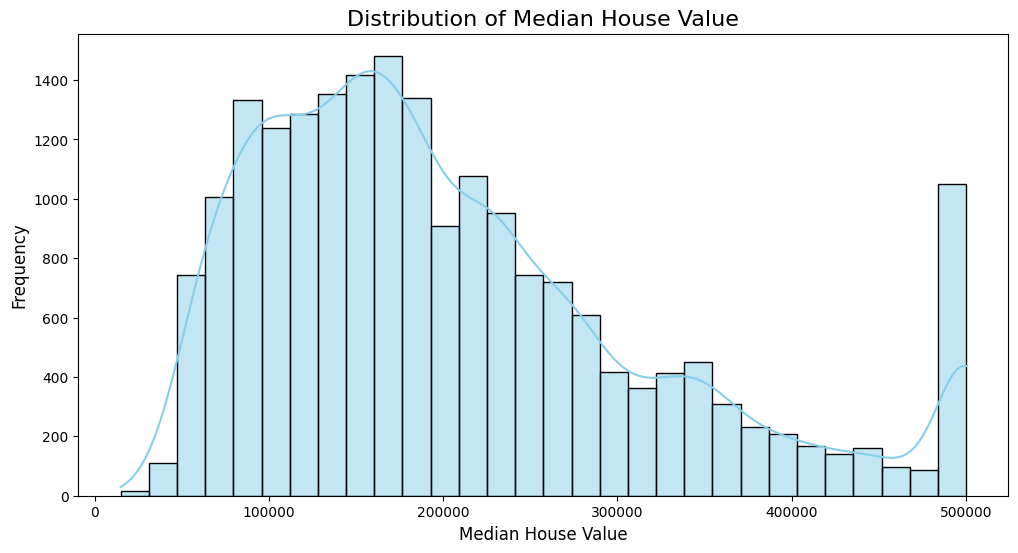

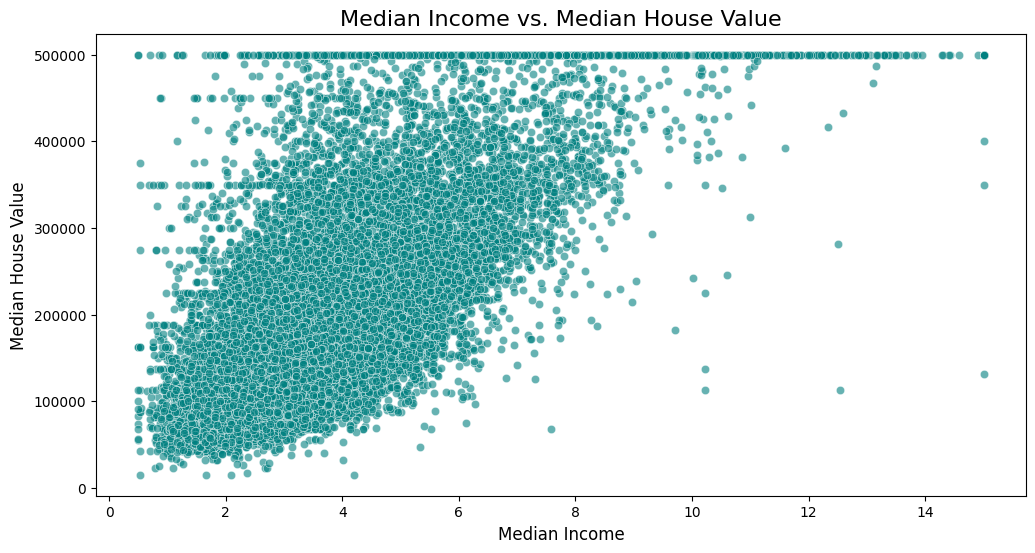

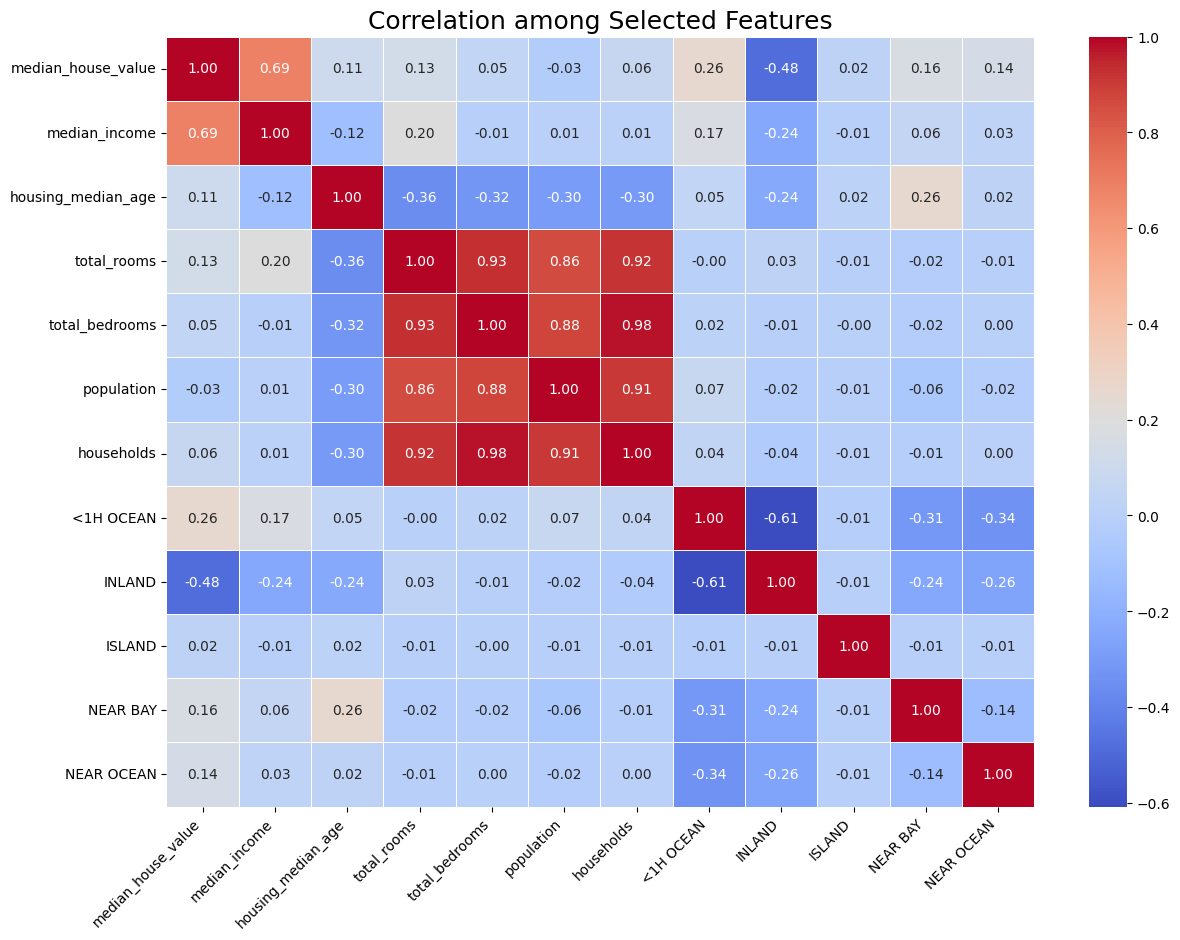

In [14]:
# Distribution of Median House Value
plt.figure(figsize=(12, 6))  # Adjusted figsize for better proportions
sns.histplot(cal_housing_final['median_house_value'], kde=True, color='skyblue', bins=30)
plt.title('Distribution of Median House Value', fontsize=16)  # Increased title font size
plt.xlabel('Median House Value', fontsize=12)  # Added x-axis label
plt.ylabel('Frequency', fontsize=12)  # Added y-axis label
plt.show()

# Relationship between Median Income and Median House Value
plt.figure(figsize=(12, 6))  # Adjusted figsize
sns.scatterplot(x='median_income', y='median_house_value', data=cal_housing_final, alpha=0.6, color='teal')
plt.title('Median Income vs. Median House Value', fontsize=16)  # Increased title font size
plt.xlabel('Median Income', fontsize=12)  # Added x-axis label
plt.ylabel('Median House Value', fontsize=12)  # Added y-axis label
plt.show()

# Correlation Heatmap (selected numeric features)
numeric_features = ['median_house_value', 'median_income', 'housing_median_age',
                    'total_rooms', 'total_bedrooms', 'population', 'households',
                    '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
corr_matrix = cal_housing_final[numeric_features].corr()
plt.figure(figsize=(14, 10))  # Adjusted figsize for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation among Selected Features', fontsize=18)  # Increased title font size
plt.xticks(rotation=45, ha='right')  # Rotated x-axis labels for better readability
plt.yticks(rotation=0)  # Kept y-axis labels horizontal
plt.show()

# 2.5) INSIGHTS / HYPOTHESES
# - Higher 'median_income' districts tend to have higher 'median_house_value'.
# - 'Housing_median_age' might have a moderate correlation with house values.
# - The location (longitude, latitude) is also critical to capture via more advanced techniques.

# 2.6) Spliting the data
This section the data is split into the following;


*   Training data - this is to train the model
*   Test data - to test the model during training
*   Validation data - to validate the best model with data not seen before

This will be done as Train data 80%, Test data 10% and Validation Data 10%



In [15]:
train_data, test_data, val_data = cal_housing_final[:16347], cal_housing_final[16347:18390], cal_housing_final[18390:]
print(f"\nPercentage of Train Data: {round(len(train_data)/len(cal_housing_final)*100,2)}%")
print(f"Percentage of Test Data: {round(len(test_data)/len(cal_housing_final)*100,2)}%")
print(f"Percentage of Validation Data: {round(len(val_data)/len(cal_housing_final)*100,2)}%")


Percentage of Train Data: 80.0%
Percentage of Test Data: 10.0%
Percentage of Validation Data: 10.0%


<Axes: xlabel='latitude', ylabel='longitude'>

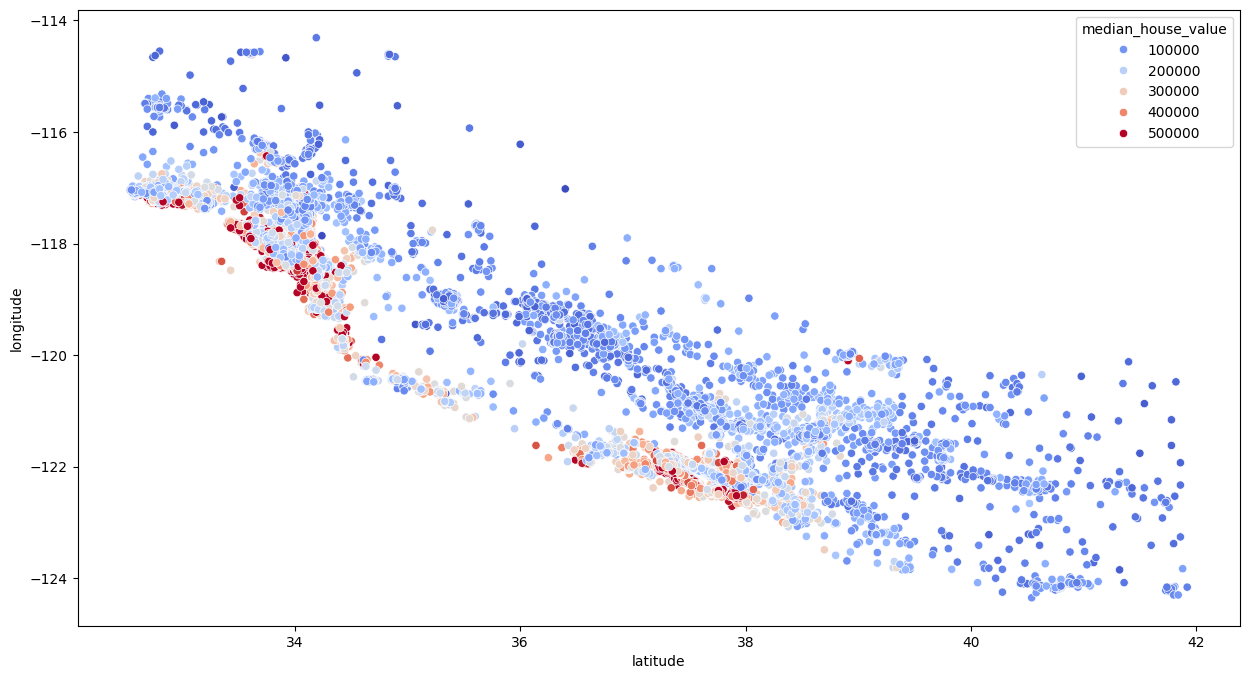

In [16]:
#@title Visualize the training data as, longitude vs latitude, title sort of shows where the high value houses are located, takes a 'map' shape like California.

plt.figure(figsize=(15, 8))
sns.scatterplot(x=train_data['latitude'], y=train_data['longitude'], hue=
train_data['median_house_value'],palette=
                'coolwarm')

# 2.7) Example of Feature scaling
### Feature Scaling: Using the min-max scaling method for each feature:
$$
 x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}
$$

In [17]:
#@title Feature scaling example
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

X_train_scaled_features = train_data[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].apply(min_max_scaling)
X_val_scaled_features = test_data[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].apply(min_max_scaling)
X_train_scaled_features


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14416,0.708167,0.026652,0.372549,0.024391,0.042837,0.014575,0.041447,0.185094
16383,0.304781,0.583156,0.019608,0.162801,0.172901,0.093113,0.157072,0.274976
7731,0.618526,0.147122,0.588235,0.094842,0.132081,0.064692,0.131414,0.187846
1410,0.227092,0.575693,0.568627,0.031996,0.042527,0.019677,0.036020,0.164970
1335,0.245020,0.581023,0.058824,0.055166,0.092348,0.025871,0.075493,0.248390
...,...,...,...,...,...,...,...,...
16951,0.200199,0.530917,0.647059,0.090467,0.086606,0.048827,0.090132,0.427304
20210,0.509960,0.187633,0.333333,0.043517,0.037560,0.019200,0.038980,0.444711
18120,0.234064,0.509595,0.647059,0.087695,0.113146,0.053536,0.112993,0.292430
15346,0.695219,0.070362,0.549020,0.033394,0.047959,0.039802,0.050000,0.105330


In [18]:
# @title 2.8) Prepare features (X) and targets (y)
X_train,y_train = train_data.to_numpy()[:,:-1],train_data.to_numpy()[:,-1]
X_test,y_test = test_data.to_numpy()[:,:-1],test_data.to_numpy()[:,-1]
X_val,y_val = val_data.to_numpy()[:,:-1],val_data.to_numpy()[:,-1]

This creates the matrices that we will require for calculations

In [19]:
# @title 2.9) Matrices example the training data
print(f"X_train Matrix: {X_train}")
print(f"X_train Matrix: {X_train.shape}")
print(f"y_train Matrix: {y_train}")
print(f"y_train Matrix: {y_train.shape}")

X_train Matrix: [[-117.24   32.79   20.   ...    0.      0.      1.  ]
 [-121.29   38.01    2.   ...    0.      0.      0.  ]
 [-118.14   33.92   31.   ...    0.      0.      0.  ]
 ...
 [-122.     37.32   34.   ...    0.      0.      0.  ]
 [-117.37   33.2    29.   ...    0.      0.      1.  ]
 [-118.07   33.83   17.   ...    0.      0.      0.  ]]
X_train Matrix: (16347, 13)
y_train Matrix: [245800. 137900. 218200. ... 244500.  99600. 142900.]
y_train Matrix: (16347,)


# 2.10) Getting the Mean Squared Error (MSE)
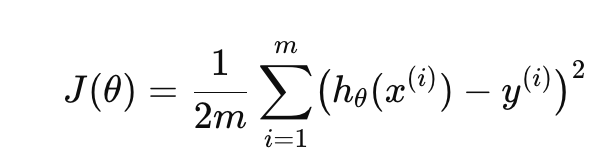

### 3. Example way to initialize the Multivariate Linear Regression Model:

The model is:
$$
 h(x) = w_1 x_1' + w_2 x_2' + w_3 x_3'+ ....w_n x_n' + b
$$
Where $ x_1' $, $ x_2' $, $ x_3' $ and $ x_n' $ are the scaled values of the features (longitude,	latitude,	housing_median_age,	total_rooms,	total_bedrooms,	population,	households,	median_income,	<1H OCEAN,	INLAND,	ISLAND,	NEAR BAY,	NEAR OCEAN).


In [20]:
# Initial parameters
w1, w2, w3, w4, w5, w6,w7, w8, w9, w10, w11, w12, w13, b = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
# @title 2.10) Scale the features

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
scaler.fit(X_train[:, :8])

def prepare_features(X):
  DF = np.copy(X)
  DF[:, :8] = scaler.transform(DF[:, :8])  # Now using the scaler object's transform method
  return DF


X_train_scaled, X_test_scaled, X_val_scaled = prepare_features(X_train), prepare_features(X_test), prepare_features(X_val)


# 4) Define and Train Models

Regression Metrics:
MAE: 32083.8490
MSE: 2398450332.4022
R2: 0.8192


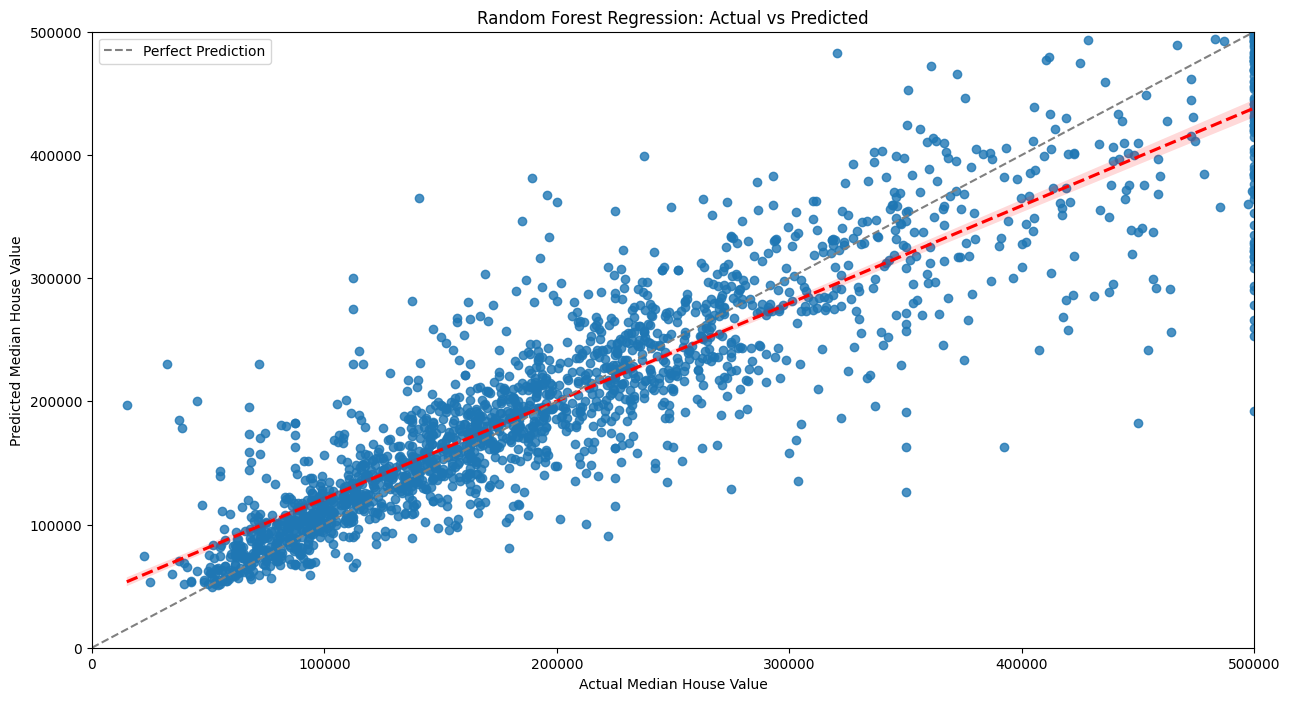

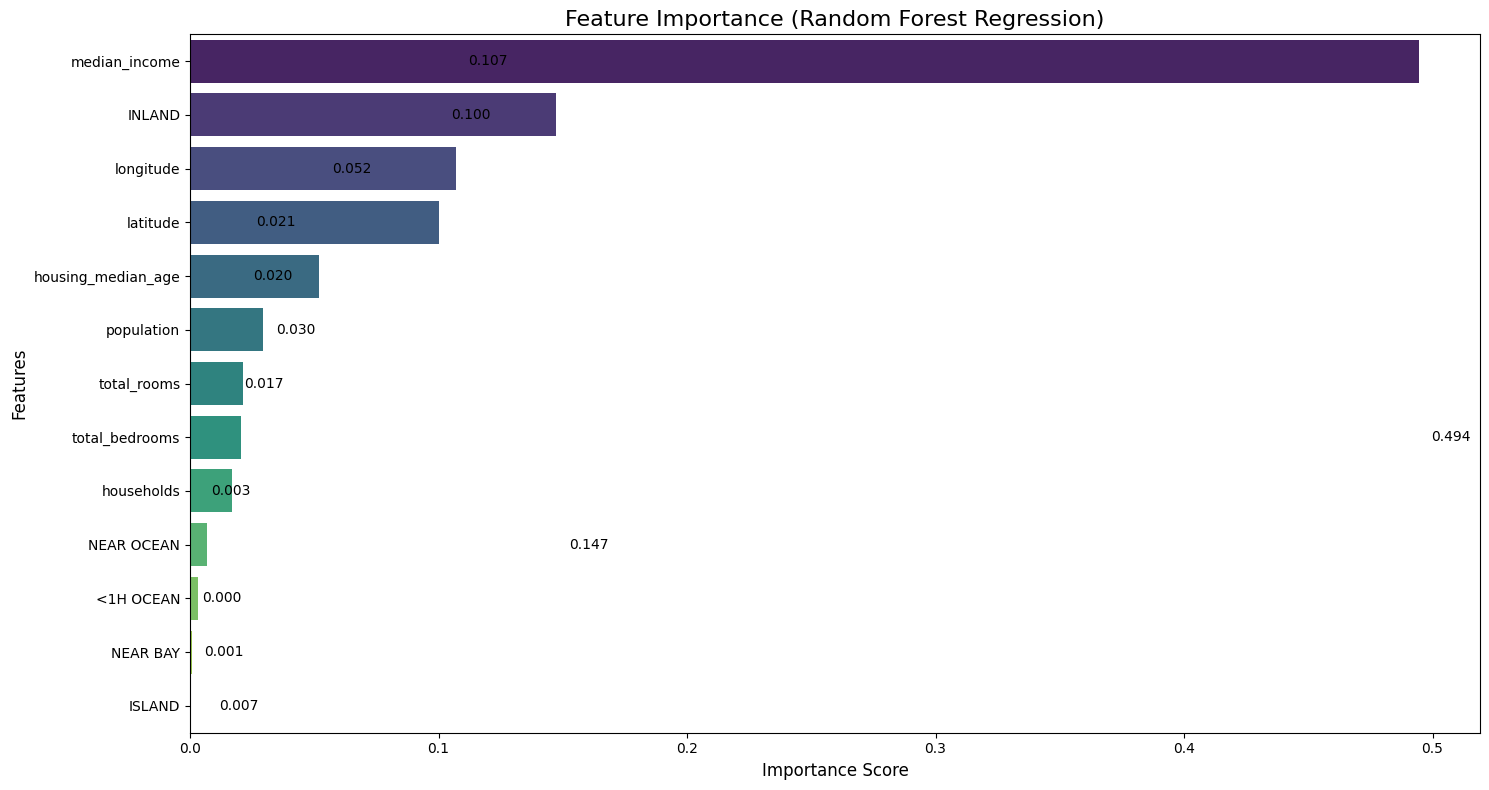

In [38]:
#@title 4.1) Random Forest

def train_and_evaluate_random_forest(X_train, y_train, X_test, y_test, feature_columns):
    """
    Trains a Random Forest Regressor, makes predictions, and evaluates performance.

    Args:
        X_train: Training data features.
        y_train: Training data target variable.
        X_test: Test data features.
        y_test: Test data target variable.
        feature_columns: List of feature names (optional, for feature importance).

    Returns:
        A tuple containing:
            - A dictionary of regression metrics (MAE, MSE, R2).
            - The trained Random Forest Regressor model.
    """
    global rf_reg_pred  # Declare rf_reg_pred as global

    # Hyperparameter grid for tuning
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2, 5]
    }

    # Initialize and train Random Forest with GridSearchCV for hyperparameter tuning
    rf_reg = GridSearchCV(
        RandomForestRegressor(random_state=42),
        param_grid,
        cv=3,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
    )
    rf_reg.fit(X_train, y_train)

    # Make predictions using the best model from GridSearchCV
    y_pred = rf_reg.predict(X_test)
    rf_reg_pred = y_pred  # Assign the predictions to rf_reg_pred


    # Calculate regression metrics
    reg_metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

    return reg_metrics, rf_reg.best_estimator_  # Return metrics and the best model


feature_columns = ['longitude', 'latitude', 'housing_median_age',
                    'total_rooms', 'total_bedrooms', 'population',
                    'households', 'median_income', '<1H OCEAN', 'INLAND',
                    'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
#reg_metrics, trained_model = train_and_evaluate_random_forest(X_train_scaled, y_train, X_test_scaled, y_test, feature_columns)
reg_metrics, best_rf = train_and_evaluate_random_forest(X_train_scaled, y_train, X_test_scaled, y_test, feature_columns)

# Print metrics (or use them for further analysis)
print("Regression Metrics:")
for metric, value in reg_metrics.items():
    print(f"{metric}: {value:.4f}")

# Access the trained model for later use if needed
# Example: predictions on new data
# new_data_predictions = trained_model.predict(new_data_scaled)


# Plot actual vs predicted values
plt.figure(figsize=(15, 8))

# Using seaborn for a more visually appealing scatter plot
sns.regplot(x=y_test, y=rf_reg_pred, scatter_kws={'alpha':0.8}, line_kws={'color': 'red', 'linestyle':'--'})

plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Random Forest Regression: Actual vs Predicted')

# Adding a 45-degree line for perfect prediction
plt.xlim(0, y_test.max())  # Setting limits to ensure line visibility
plt.ylim(0, rf_reg_pred.max())
plt.plot(np.linspace(0, y_test.max(), 10), np.linspace(0, y_test.max(), 10), color='gray', linestyle='--', label='Perfect Prediction')

plt.legend()  # Show legend
plt.show()


# Feature importance for regression
feature_importance_reg = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plotting improvements
plt.figure(figsize=(15, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_reg, hue='feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance (Random Forest Regression)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add value labels to bars
for index, row in feature_importance_reg.iterrows():
    plt.text(row.importance + 0.005, index, f"{row.importance:.3f}", va='center', fontsize=10)

plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [43]:
#@title 4.2) Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

In [44]:
#@title 4.3) Ridge
ridge_model = Ridge()
params_ridge = {'alpha': [0.1, 1, 10, 50]}
ridge_grid = GridSearchCV(ridge_model, params_ridge, cv=5,
                          scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_


In [42]:
#@title 4.4) Neural Network (MLPRegressor)
#import tensorflow as tf  # Import TensorFlow for Keras


from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define models and parameters with increased max_iter
nn_model = MLPRegressor(random_state=42, max_iter=100)  # Increased max_iter
params_nn = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3]
}

# Perform GridSearchCV with the updated model
nn_grid = GridSearchCV(nn_model, params_nn, cv=3, n_jobs=-1,
                       scoring='neg_root_mean_squared_error')
nn_grid.fit(X_train_scaled, y_train)  # Use scaled data here as well
best_nn = nn_grid.best_estimator_

'''
# Define models and parameters
nn_model = MLPRegressor(random_state=42, max_iter=10)
params_nn = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-5, 1e-4, 1e-3]
}

# Custom callback for loss logging
class LossHistory(tf.keras.callbacks.Callback):
       def on_train_begin(self, logs={}):
           self.losses = []

       def on_epoch_end(self, epoch, logs={}):
           self.losses.append(logs.get('loss'))

# Keras wrapper for MLPRegressor
def create_keras_wrapper(nn_model):
       input_dim = nn_model.n_features_in_
       model = tf.keras.models.Sequential()
       for layer_size in nn_model.hidden_layer_sizes:
           model.add(tf.keras.layers.Dense(
               layer_size, activation=nn_model.activation, input_shape=(input_dim,) if model.layers else None
           ))
       model.add(tf.keras.layers.Dense(1, activation='linear'))
       model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=nn_model._optimizer.learning_rate))
       return model

# Train and evaluate Neural Network
history = LossHistory()
nn_grid = GridSearchCV(estimator=nn_model, param_grid=params_nn, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
nn_grid.fit(X_train, y_train)
best_nn = nn_grid.best_estimator_
keras_wrapper = create_keras_wrapper(best_nn)
keras_wrapper.fit(X_train, y_train, epochs=best_nn.n_iter_, callbacks=[history], verbose=0)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history.losses)
plt.title('Neural Network Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
'''

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


"\n# Define models and parameters\nnn_model = MLPRegressor(random_state=42, max_iter=10)\nparams_nn = {\n    'hidden_layer_sizes': [(64,), (128,), (64, 64)],\n    'activation': ['relu', 'tanh'],\n    'alpha': [1e-5, 1e-4, 1e-3]\n}\n\n# Custom callback for loss logging\nclass LossHistory(tf.keras.callbacks.Callback):\n       def on_train_begin(self, logs={}):\n           self.losses = []\n\n       def on_epoch_end(self, epoch, logs={}):\n           self.losses.append(logs.get('loss'))\n\n# Keras wrapper for MLPRegressor\ndef create_keras_wrapper(nn_model):\n       input_dim = nn_model.n_features_in_\n       model = tf.keras.models.Sequential()\n       for layer_size in nn_model.hidden_layer_sizes:\n           model.add(tf.keras.layers.Dense(\n               layer_size, activation=nn_model.activation, input_shape=(input_dim,) if model.layers else None\n           ))\n       model.add(tf.keras.layers.Dense(1, activation='linear')) \n       model.compile(loss='mse', optimizer=tf.keras.opti

In [ ]:

# Define the model
model = Sequential()
model.add(tf.keras.layers.Input(shape=(X_train_scaled.shape[1],))) # Input layer with specified shape
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))


# Define the learning rate
learning_rate = 0.1  # You can change this value

# Compile the model with the Adam optimizer and specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])


# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model with feedback after each epoch
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping],
    verbose=1  # Set verbose to 1 for feedback after each epoch
)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2= r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}, R2:{r2:.2f}")

Epoch 1/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 56869330944.0000 - mse: 56869330944.0000 - val_loss: 51564498944.0000 - val_mse: 51564498944.0000
Epoch 2/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 47968813056.0000 - mse: 47968813056.0000 - val_loss: 31694073856.0000 - val_mse: 31694073856.0000
Epoch 3/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 26033999872.0000 - mse: 26033999872.0000 - val_loss: 13480881152.0000 - val_mse: 13480881152.0000
Epoch 4/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11307783168.0000 - mse: 11307783168.0000 - val_loss: 8746631168.0000 - val_mse: 8746631168.0000
Epoch 5/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8034292736.0000 - mse: 8034292736.0000 - val_loss: 7276686336.0000 - val_mse: 7276686336.0000
Epoch 6/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6694259712.0000 - mse: 6694259712.0000 - val_loss: 6385487360.0000 - val_mse: 6385487360.0000
Epoch 7/1000
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

In [ ]:
#@title 5) Evaluate
def print_metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2= r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}, R2:{r2:.2f}")

y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_ridge = best_ridge.predict(X_test_scaled)
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_nn = best_nn.predict(X_test_scaled)

print("\n=== MODEL PERFORMANCE ===")
print_metrics("Best Random Forest", y_test, y_pred_rf)
print_metrics("Linear Regression", y_test, y_pred_lr)
print_metrics("Best Ridge", y_test, y_pred_ridge)
print_metrics("Best Neural Network", y_test, y_pred_nn)



# 6) Feature Engineering
From the above correlation map we note that, total_rooms on its self is not very intesting, a ratio of how many of these are bedrooms would make more sense.
Also avarage household occupancy would be an iteresting feature, so is average rooms and average occupancy.

In [47]:
cal_housing_final.loc[:, 'av_bedroom'] = cal_housing_final['total_bedrooms'] / cal_housing_final['total_rooms']
cal_housing_final.loc[:, 'av_occupancy'] = cal_housing_final['population'] / cal_housing_final['households']
cal_housing_final.loc[:, 'av_rooms'] = cal_housing_final['total_rooms'] / cal_housing_final['households']
cal_housing_final.head()

<ipython-input-47-871b792161f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_housing_final.loc[:, 'av_bedroom'] = cal_housing_final['total_bedrooms'] / cal_housing_final['total_rooms']
<ipython-input-47-871b792161f5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_housing_final.loc[:, 'av_occupancy'] = cal_housing_final['population'] / cal_housing_final['households']
<ipython-input-47-871b792161f5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN,median_house_value,av_bedroom,av_occupancy,av_rooms
14416,-117.24,32.79,20.0,961.0,278.0,525.0,254.0,3.1838,0,0,0,0,1,245800.0,0.289282,2.066929,3.783465
16383,-121.29,38.01,2.0,6403.0,1116.0,3327.0,957.0,4.4871,0,1,0,0,0,137900.0,0.174293,3.476489,6.690700
7731,-118.14,33.92,31.0,3731.0,853.0,2313.0,801.0,3.2237,1,0,0,0,0,218200.0,0.228625,2.887640,4.657928
1410,-122.07,37.94,30.0,1260.0,276.0,707.0,221.0,2.8920,0,0,0,1,0,220800.0,0.219048,3.199095,5.701357
1335,-121.89,37.99,4.0,2171.0,597.0,928.0,461.0,4.1016,0,1,0,0,0,170500.0,0.274988,2.013015,4.709328


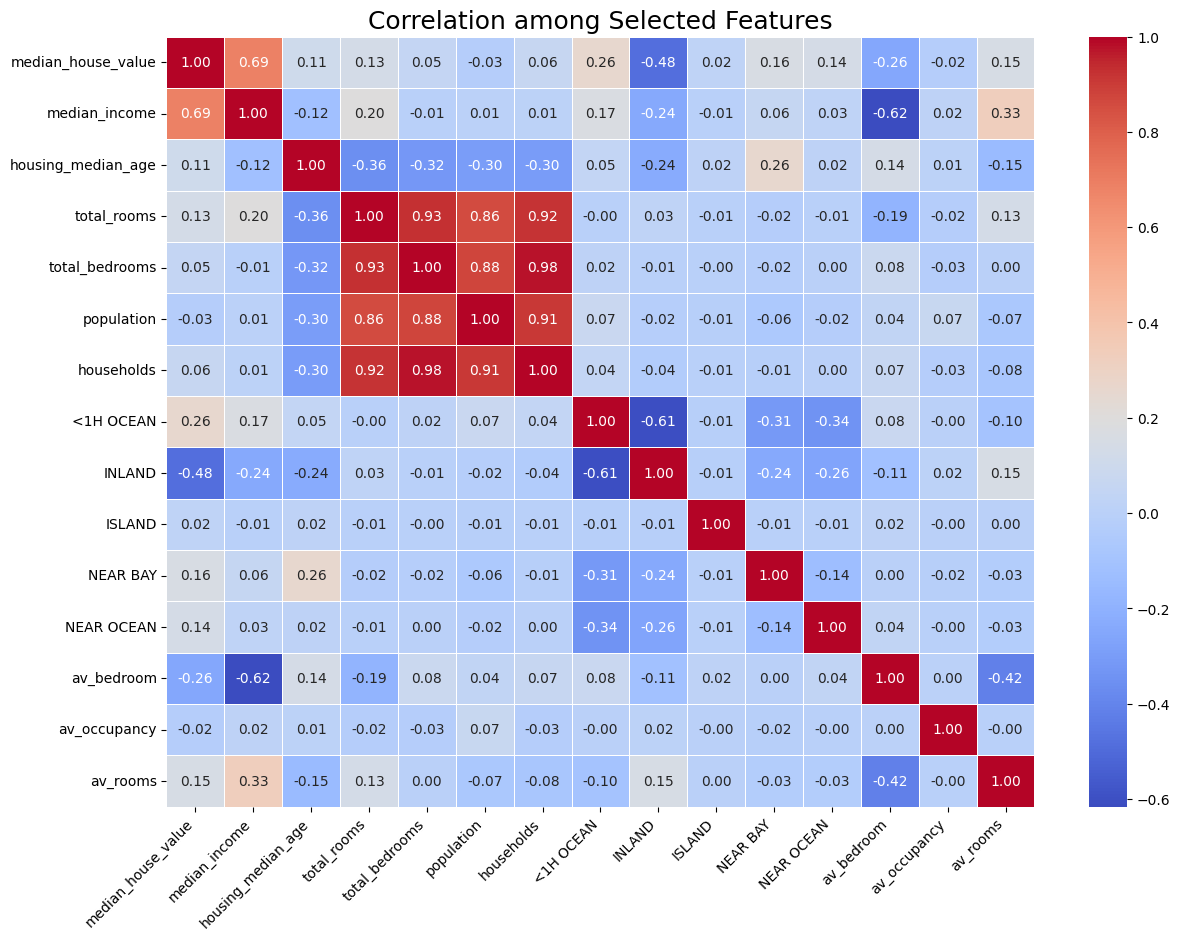

In [48]:
# Correlation Heatmap (selected numeric features)
numeric_features = ['median_house_value', 'median_income', 'housing_median_age',
                    'total_rooms', 'total_bedrooms', 'population', 'households',
                    '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN', 'av_bedroom',	'av_occupancy',	'av_rooms']
corr_matrix = cal_housing_final[numeric_features].corr()
plt.figure(figsize=(14, 10))  # Adjusted figsize for better readability
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation among Selected Features', fontsize=18)  # Increased title font size
plt.xticks(rotation=45, ha='right')  # Rotated x-axis labels for better readability
plt.yticks(rotation=0)  # Kept y-axis labels horizontal
plt.show()